**Problem 2:**
**Demosaicing**

Install the rawpy package.

In [1]:
!pip install rawpy 

     |████████████████████████████████| 1.6MB 4.6MB/s 


Import all the necessary libararies.

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import rawpy
from matplotlib import transforms

Mount google drive to get input images. 

In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Display the original image. 

(-0.5, 4311.5, 2867.5, -0.5)

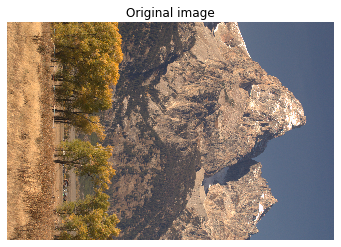

In [47]:
tetnos_raw = rawpy.imread('/content/drive/My Drive/tetons.nef')
rgb = tetnos_raw.postprocess()
rgb = np.rot90(rgb)
rgb = np.rot90(rgb)
rgb = np.rot90(rgb)
plt.imshow(rgb)
plt.title('Original image')
plt.axis('off')
cv2.imwrite('/content/drive/My Drive/tetnos_original.png', rgb) 

Extract only the red,green and blue channels from the raw image.The raw image has a paramenter 'raw_colors' which contains the integer 0 if the pixel is red, 1 or 3 if the pixel is green and 2 if the pixel is blue. 

In [0]:
with rawpy.imread('/content/drive/My Drive/tetons.nef') as raw:
  raw_image = raw.raw_image.copy()
  raw_colors=raw.raw_colors.copy()
raw_img=raw_image.flatten()
raw_clr=raw_colors.flatten()

#extract green pixels only
C=1
i=np.argwhere(raw_clr==C).flatten()
g1=raw_img[i] 
g1=np.reshape(g1,(1434,2160))
#plt.imsave('/content/drive/My Drive/tetnos_subsample_g.png',g)

#extract red pixels only
C=0
i=np.argwhere(raw_clr==C).flatten()
r=raw_img[i] 
r=np.reshape(r,(1434,2160))
#plt.imsave('/content/drive/My Drive/tetnos_subsample_r.png',r)

#extract blue pixels only
C=2
i=np.argwhere(raw_clr==C).flatten()
b=raw_img[i] 
b=np.reshape(b,(1434,2160))
#plt.imsave('/content/drive/My Drive/tetnos_subsample_b.png',b)

#Extract the second green channel
C=3
i=np.argwhere(raw_clr==C).flatten()
g2=raw_img[i] 
g2=np.reshape(g2,(1434,2160))
#combine the two green channels 
g = (g1+g2)/3.5


Display the subsampled images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Subsamples Image')

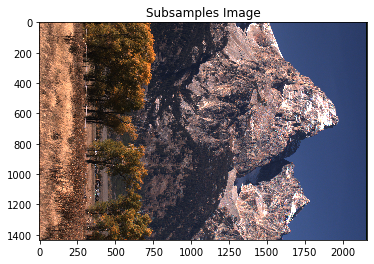

In [48]:
tetnos_subsample = np.dstack((r,g,b))
plt.imshow(tetnos_subsample/(6*255))
plt.title('Subsamples Image')


Nearest neighbor interpolation using the subsamples r,g,b channels. 

In [0]:
def nn(r,g1,b,g2):
  w, h = r.shape[:2]
  xNew = int(w *  2); 
  yNew = int(h *  2);
  xScale = xNew/(w-1); 
  yScale = yNew/(h-1);
  newImage_r = np.zeros((xNew,yNew),dtype='float32');
  newImage_g1 = np.zeros((xNew,yNew),dtype='float32');
  newImage_b = np.zeros((xNew,yNew),dtype='float32');
  newImage_g2 = np.zeros((xNew,yNew),dtype='float32');

  for i in range(xNew-1): 
   for j in range(yNew-1): 
       newImage_r[i + 1][j + 1]= r[1 + int(i / xScale)][1 + int(j / yScale)] 
       newImage_g1[i + 1][j + 1]= g1[1 + int(i / xScale)][1 + int(j / yScale)] 
       newImage_b[i + 1][j + 1]= b[1 + int(i / xScale)][1 + int(j / yScale)]
       newImage_g2[i + 1][j + 1]= g2[1 + int(i / xScale)][1 + int(j / yScale)] 
  
  newImage_g = (newImage_g1+newImage_g2)/3
  tetnos_nn=np.dstack((newImage_r/(6*255),newImage_g/(6*255),newImage_b/(6*255)))
  return tetnos_nn



In [0]:
tetnos_nn = nn(r,g1,b,g2) 
plt.imsave('/content/drive/My Drive/tetnos_nn.png',tetnos_nn)

Funtion implementing bilinear as well as edge based demosaicing. 

In [0]:
def bl_n_edge():
  r_new=np.zeros((2868,4320),dtype='uint64')
  g_new=np.zeros((2868,4320),dtype='uint64')
  b_new=np.zeros((2868,4320),dtype='uint64')
  g_edge=np.zeros((2868,4320),dtype='uint64')

  for i in range (0,2868-2):
    for j in range(0,4320-2):
      if(i%2==1 and j%2 == 0): #case when green pixel is present with red on top and bottom
        r_new[i][j]= (raw_image[i-1][j]+raw_image[i+1][j])/2
        b_new[i][j]= (raw_image[i][j-1]+raw_image[i][j+1])/2
        g_new[i][j]= raw_image[i][j]
        g_edge[i][j]= raw_image[i][j] 

      elif (i%2== 0 and j%2==0): #case when red pixel is present 
        r_new[i][j] = raw_image[i][j]
        b_new[i][j] = (raw_image[i-1][j-1]+raw_image[i+1][j-1]+raw_image[i-1][j+1]+raw_image[i+1][j+1])/4
        g_new[i][j]= (raw_image[i-1][j]+raw_image[i][j+1]+raw_image[i+1][j]+raw_image[i][j-1])/4
        
        #edge based demosaicing for green channel 
        if( abs(raw_image[i-2][j]-raw_image[i+2][j])< abs(raw_image[i][j+2]-raw_image[i][j-2])):
          g_edge[i][j]= (raw_image[i-1][j]+raw_image[i+1][j])/2
        elif(abs(raw_image[i-2][j]-raw_image[i+2][j])> abs(raw_image[i][j+2]-raw_image[i][j-2])):
          g_edge[i][j]= (raw_image[i][j+1]+raw_image[i][j-1])/2
        else:
          g_edge[i][j] = (raw_image[i-1][j]+raw_image[i][j+1]+raw_image[i+1][j]+raw_image[i][j-1])/4

      elif(i%2==0 and j%2==1): #case when green pixel is present with blue on top and bottom
        r_new[i][j]=(raw_image[i][j+1]+raw_image[i][j-1])/2 
        b_new[i][j]=(raw_image[i+1][j]+raw_image[i-1][j])/2
        g_new[i][j]=raw_image[i][j]
        g_edge[i][j]= raw_image[i][j] 

      else: #case when blue pixel is present  
        r_new[i][j]=(raw_image[i-1][j-1]+raw_image[i-1][j+1]+raw_image[i+1][j+1]+raw_image[i+1][j-1])/4
        b_new[i][j]=raw_image[i][j]
        g_new[i][j]= (raw_image[i-1][j]+raw_image[i][j+1]+raw_image[i+1][j]+raw_image[i][j-1])/4 

        #edge based demosaicing for green channel 
        if( abs(raw_image[i-2][j]-raw_image[i+2][j])< abs(raw_image[i][j+2]-raw_image[i][j-2])):
          g_edge[i][j]= (raw_image[i-1][j]+raw_image[i+1][j])/2
        elif(abs(raw_image[i-2][j]-raw_image[i+2][j])> abs(raw_image[i][j+2]-raw_image[i][j-2])):
          g_edge[i][j]= (raw_image[i][j+1]+raw_image[i][j-1])/2
        else:
          g_edge[i][j] = (raw_image[i-1][j]+raw_image[i][j+1]+raw_image[i+1][j]+raw_image[i][j-1])/4

  tetnos_bilinear = np.dstack((r_new,g_new/2,b_new))
  tetnos_edge = np.dstack((r_new,g_edge/2,b_new))
  cv2.imwrite('/content/drive/My Drive/tetnos_bl.png',tetnos_bilinear)
  cv2.imwrite('/content/drive/My Drive/tetnos_edge.png',tetnos_edge)
  return (tetnos_bilinear,tetnos_edge)

In [10]:
bl_image , edge_image = bl_n_edge()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in ushort_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ushort_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in ushort_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in ushort_scalars


Display the images from all the three methods of demosaicing.
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 4319.5, 2867.5, -0.5)

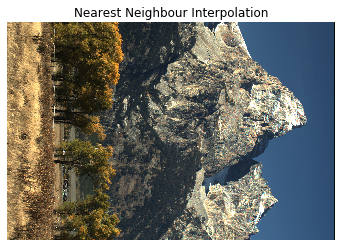

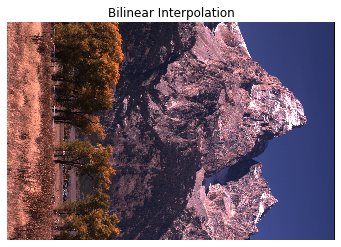

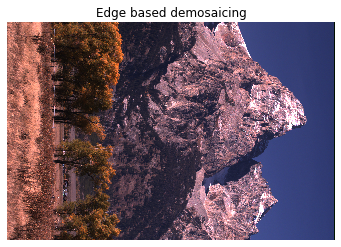

In [27]:
plt.figure()
plt.imshow(tetnos_nn)
plt.title('Nearest Neighbour Interpolation')
plt.axis('off')
plt.figure()
plt.imshow(bl_image/(6*255))
plt.title('Bilinear Interpolation')
plt.axis('off')
plt.figure()
plt.imshow(edge_image/(6*255))
plt.title('Edge based demosaicing')
plt.axis('off')

Display two zoomed in regions for all the three methods. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 89.5, 29.5, -0.5)

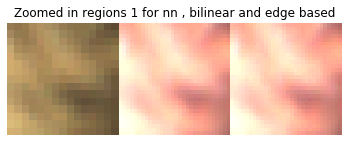

In [25]:
blow_up1 = np.zeros((30,90,3))
blow_up1[:,0:30,:] = tetnos_nn[100:130,100:130,:]
blow_up1[:,30:60,:]= bl_image[100:130,100:130,:]/(3*255)
blow_up1[:,60:90,:]= edge_image[100:130,100:130,:]/(3*255)
plt.imshow(blow_up1)
plt.title('Zoomed in regions 1 for nn , bilinear and edge based')
plt.axis('off')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 89.5, 29.5, -0.5)

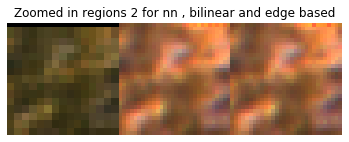

In [43]:
blow_up2 = np.zeros((30,90,3))
blow_up2[:,0:30,:] = tetnos_nn[0:30,1000:1030,:]
blow_up2[:,30:60,:]= bl_image[0:30,1000:1030,:]/(3*255)
blow_up2[:,60:90,:]= edge_image[0:30,1000:1030,:]/(3*255)
plt.imshow(blow_up2)
plt.title('Zoomed in regions 2 for nn , bilinear and edge based')
plt.axis('off')